In [6]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [2]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
import numpy as np


# Setup the Open-Meteo API client with cache and retry on error

In [3]:
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)


# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below

In [5]:
url ="https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": 40.7128,
	"longitude": -74.006,
	"start_date": "2022-01-01",
	"end_date": "2025-04-20",
	"hourly": ["temperature_2m", "relative_humidity_2m", "precipitation"]
}
responses = openmeteo.weather_api(url, params=params)


# Process first location. Add a for-loop for multiple locations or weather models

In [6]:
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 40.71033477783203°N -73.99308776855469°E
Elevation 32.0 m asl
Timezone NoneNone
Timezone difference to GMT+0 0 s


# Process hourly data. The order of variables needs to be the same as requested.

In [7]:
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


                           date  temperature_2m  relative_humidity_2m  \
0     2022-01-01 00:00:00+00:00        9.631001                  94.0   
1     2022-01-01 01:00:00+00:00        9.631001                  92.0   
2     2022-01-01 02:00:00+00:00        9.581000                  96.0   
3     2022-01-01 03:00:00+00:00        9.881001                  95.0   
4     2022-01-01 04:00:00+00:00        9.831000                  94.0   
...                         ...             ...                   ...   
28939 2025-04-20 19:00:00+00:00       20.281000                  22.0   
28940 2025-04-20 20:00:00+00:00       20.480999                  22.0   
28941 2025-04-20 21:00:00+00:00       20.380999                  22.0   
28942 2025-04-20 22:00:00+00:00       19.980999                  20.0   
28943 2025-04-20 23:00:00+00:00       19.031000                  20.0   

       precipitation  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4       

# convert to csv

In [9]:
hourly_dataframe.to_csv()
hourly_dataframe

,date,temperature_2m,relative_humidity_2m,precipitation
0,2022-01-01 00:00:00+00:00,9.631001,94.0,0.0
1,2022-01-01 01:00:00+00:00,9.631001,92.0,0.0
2,2022-01-01 02:00:00+00:00,9.581000,96.0,0.0
3,2022-01-01 03:00:00+00:00,9.881001,95.0,0.0
4,2022-01-01 04:00:00+00:00,9.831000,94.0,0.0
...,...,...,...,...
28939,2025-04-20 19:00:00+00:00,20.281000,22.0,0.0
28940,2025-04-20 20:00:00+00:00,20.480999,22.0,0.0
28941,2025-04-20 21:00:00+00:00,20.380999,22.0,0.0
28942,2025-04-20 22:00:00+00:00,19.980999,20.0,0.0


In [10]:
hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28944 entries, 0 to 28943
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   date                  28944 non-null  datetime64[ns, UTC]
 1   temperature_2m        28944 non-null  float32            
 2   relative_humidity_2m  28944 non-null  float32            
 3   precipitation         28944 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(3)
memory usage: 565.4 KB


In [11]:
hourly_dataframe.value_counts()

date                       temperature_2m  relative_humidity_2m  precipitation
2022-01-01 00:00:00+00:00  9.631001        94.0                  0.0              1
2024-03-14 06:00:00+00:00  7.181000        85.0                  0.0              1
2024-03-15 08:00:00+00:00  13.231000       55.0                  0.0              1
2024-03-15 07:00:00+00:00  11.781000       67.0                  0.0              1
2024-03-15 06:00:00+00:00  10.981000       69.0                  0.0              1
                                                                                 ..
2023-02-06 19:00:00+00:00  10.081000       49.0                  0.0              1
2023-02-06 18:00:00+00:00  10.431001       45.0                  0.0              1
2023-02-06 17:00:00+00:00  10.831000       44.0                  0.0              1
2023-02-06 16:00:00+00:00  9.931001        48.0                  0.0              1
2025-04-20 23:00:00+00:00  19.031000       20.0                  0.0             

In [12]:
hourly_dataframe.describe()

,temperature_2m,relative_humidity_2m,precipitation
count,28944.000000,28944.000000,28944.000000
mean,12.756255,63.364464,0.104668
std,9.795139,20.077009,1.279206
min,-15.769000,10.000000,0.000000
25%,5.081000,47.000000,0.000000
50%,12.281000,62.000000,0.000000
75%,20.980999,81.000000,0.000000
max,36.731003,100.000000,100.400002


In [13]:
hourly_dataframe.corr()

,date,temperature_2m,relative_humidity_2m,precipitation
date,1.000000,-0.044144,-0.025724,-0.008063
temperature_2m,-0.044144,1.000000,0.013123,-0.001494
relative_humidity_2m,-0.025724,0.013123,1.000000,0.113226
precipitation,-0.008063,-0.001494,0.113226,1.000000


In [14]:
sns.set(style="whitegrid")

# temperature over time

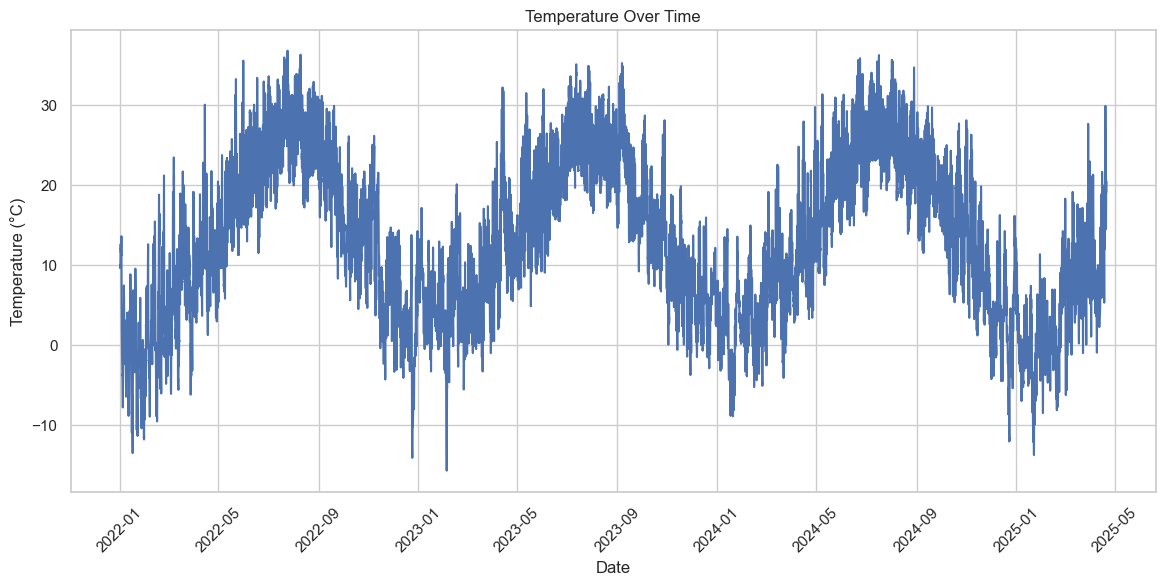

In [15]:

plt.figure(figsize=(14,6))
sns.lineplot(x='date', y='temperature_2m', data=hourly_dataframe)
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.show()

# humidity over time

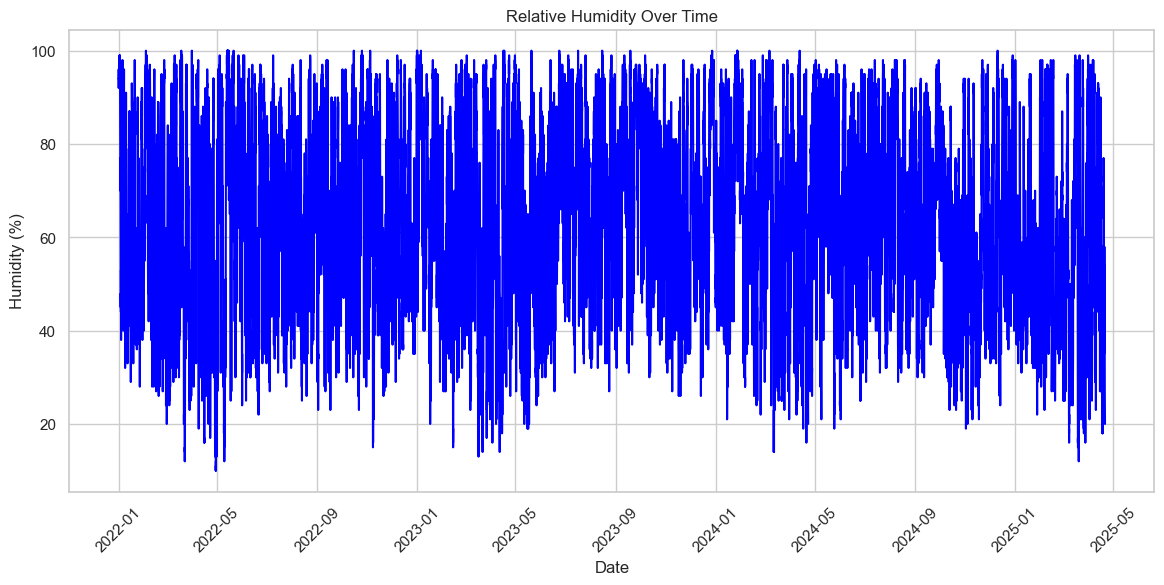

In [16]:

plt.figure(figsize=(14,6))
sns.lineplot(x='date', y='relative_humidity_2m', data=hourly_dataframe, color="blue")
plt.title('Relative Humidity Over Time')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.xticks(rotation=45)
plt.show()

# precipitation over time

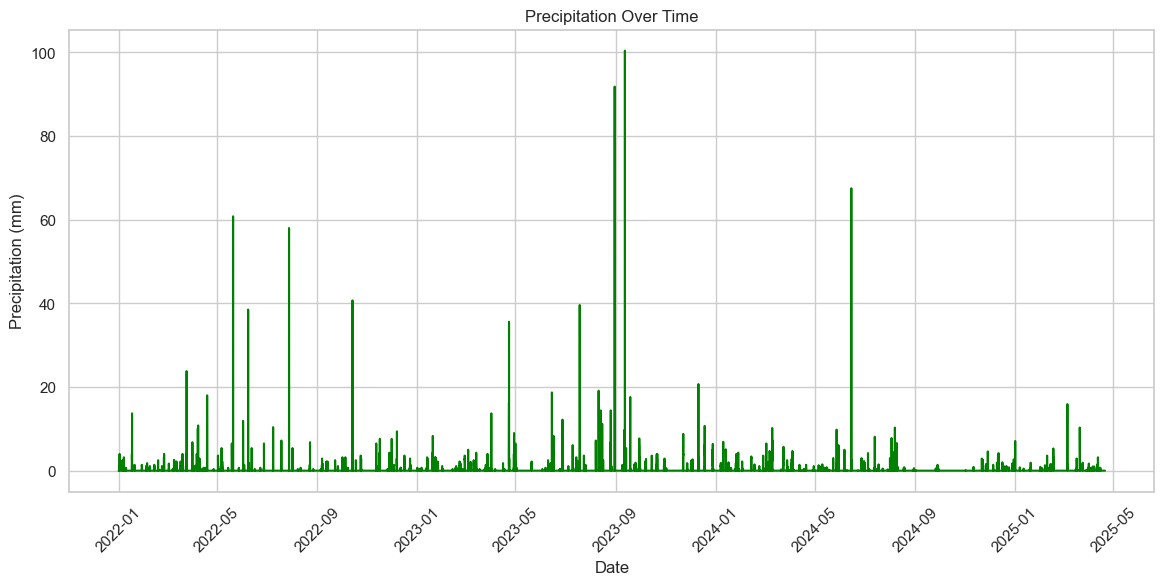

In [17]:

plt.figure(figsize=(14,6))
sns.lineplot(x='date', y='precipitation', data=hourly_dataframe, color="green")
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.xticks(rotation=45)
plt.show()

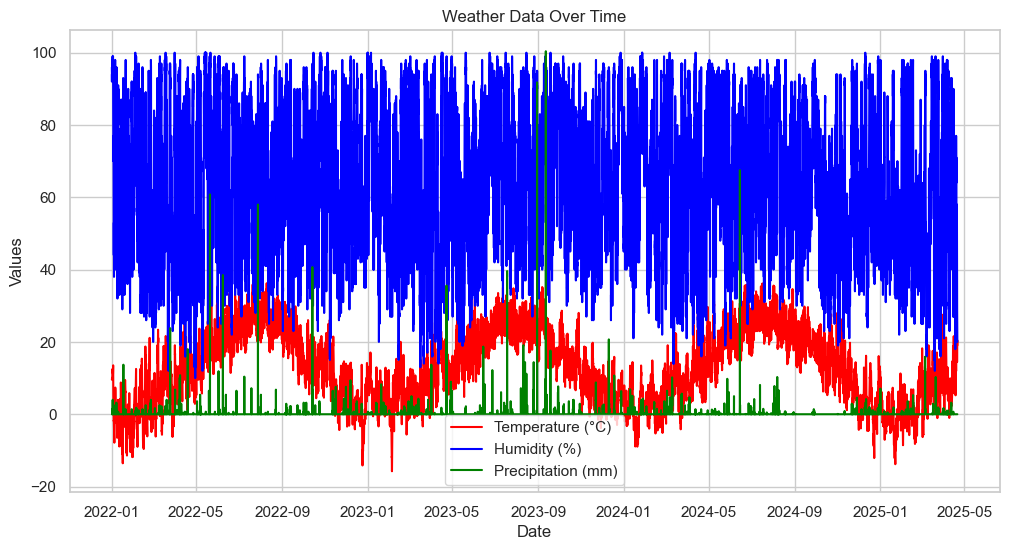

In [18]:
hourly_dataframe.set_index('date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(hourly_dataframe.index, hourly_dataframe["temperature_2m"], label="Temperature (°C)", color='red')
plt.plot(hourly_dataframe.index, hourly_dataframe["relative_humidity_2m"], label="Humidity (%)", color='blue')
plt.plot(hourly_dataframe.index, hourly_dataframe["precipitation"], label="Precipitation (mm)", color='green')
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Weather Data Over Time")
plt.legend()
plt.grid(True)
plt.show()

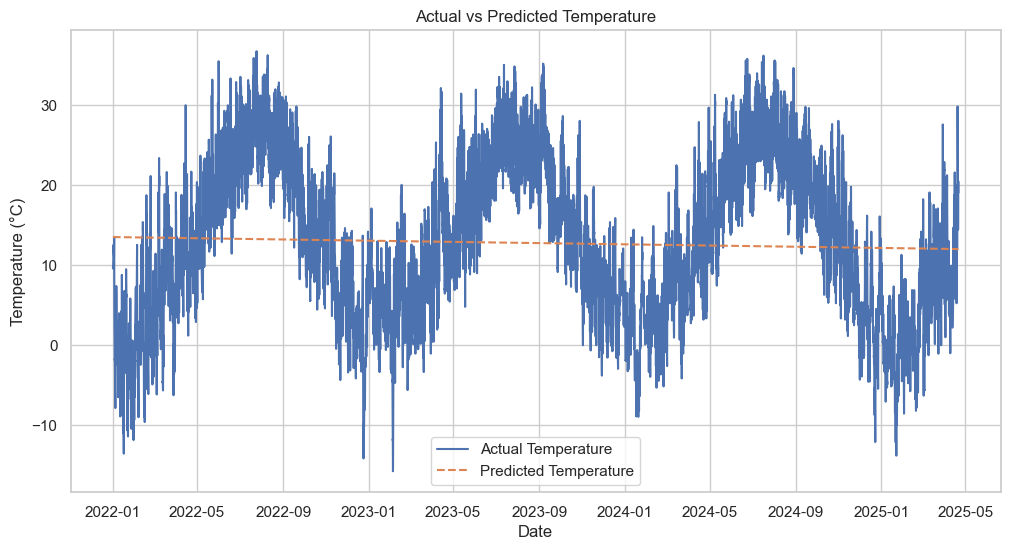

In [19]:
hourly_dataframe['time_index'] = np.arange(len(hourly_dataframe))

X = hourly_dataframe[['time_index']]
y = hourly_dataframe['temperature_2m']

model = LinearRegression()
model.fit(X, y)

hourly_dataframe['temp_prediction'] = model.predict(X)

plt.figure(figsize=(12, 6))
plt.plot(hourly_dataframe.index, hourly_dataframe['temperature_2m'], label="Actual Temperature")
plt.plot(hourly_dataframe.index, hourly_dataframe['temp_prediction'], label="Predicted Temperature", linestyle='--')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Actual vs Predicted Temperature")
plt.legend()
plt.show()
